In [64]:
%%bash
apt-get install cmake
apt-get install zliblg-dev
pip install JSAnimation
pip install gym-super-mario-bros

Reading package lists...
Building dependency tree...
Reading state information...
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...


E: Unable to locate package zliblg-dev


In [0]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [0]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [63]:
!pip install APNG

In [67]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1009'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1009'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
import numpy as np
# import cPickle as pickle
import matplotlib.pyplot as plt
from JSAnimation.IPython_display import display_animation
from matplotlib import animation

from collections import deque

%matplotlib inline

In [0]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [70]:
action_space = env.get_action_meanings()
action_space

['NOOP', 'right', 'right A', 'right B', 'right A B', 'A', 'left']

In [0]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='once'))

In [0]:
import time
from apng import APNG
from PIL import Image, ImageDraw
import IPython

/usr/local/lib/python3.6/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


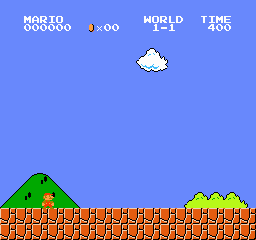

In [78]:
observation = env.reset()
r = []
infos = []
MAX_STEPS = 500
frames = np.zeros((MAX_STEPS, 240, 256, 3), dtype=np.uint8)
xs = []
valid_actions = [1,5,6]
for step in range(MAX_STEPS):
    # Render into buffer. 
    frames[step] = env.render(mode = 'rgb_array')
    observation, reward, done, info = env.step(2)#valid_actions[np.random.randint(3)])
    infos.append(info)
    r.append(reward)
    xs.append(info['x_pos'])
    
    if done:
        break

files = []
for idx, f in enumerate(frames):
  fn = "file%02d.png" % idx
  im = Image.fromarray(f,'RGB')
  im.save(fn)
  files.append(fn)
APNG.from_files(files, delay=1).save("animation.png")
IPython.display.Image("animation.png")

# prev_screen = env.render()
# display_frames_as_gif(frames)
# plt.imshow(prev_screen)

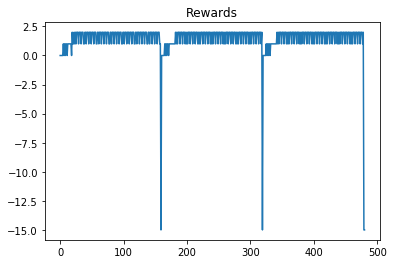

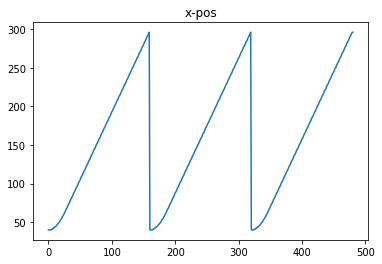

Sum of rewards is  680


In [79]:
r = np.array(r)

plt.plot(r)
plt.title('Rewards')
plt.show()

plt.plot(xs)
plt.title('x-pos')
plt.show()

print('Sum of rewards is ', r.sum())

In [0]:
def preprocess(frame):
    frame = frame/253
    frame = frame[20:210,:]
    #frame = frame[::2,::2]
    return frame

In [109]:
L = [i for i in range(10)]
L[::2]

[0, 2, 4, 6, 8]

/usr/local/lib/python3.6/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


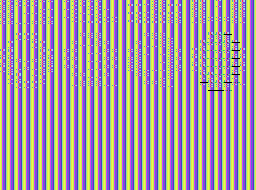

In [111]:
observation = env.reset()
r = []
infos = []
MAX_STEPS = 500
frames = np.zeros((MAX_STEPS, 240, 256, 3), dtype=np.uint8)
xs = []
valid_actions = [1,5,6]
for step in range(MAX_STEPS):
    # Render into buffer. 
    frames[step] = env.render(mode = 'rgb_array')
    observation, reward, done, info = env.step(2)#valid_actions[np.random.randint(3)])
    infos.append(info)
    r.append(reward)
    xs.append(info['x_pos'])
    
    if done:
        break

files = []
#frames=preprocess(frames)
for idx, f in enumerate(frames):
  f = preprocess(f)
  fn = "file%02d.png" % idx
  im = Image.fromarray(f,'RGB')
  im.save(fn)
  files.append(fn)
APNG.from_files(files, delay=1).save("animation.png")
IPython.display.Image("animation.png")